### 9. 분류실습-kaggle 신용카드 사기 검출
해당 데이터의 레이블인 class의 속성은 **매우 불균형한 데이터**이다. 정상적인 신용카드 트랜젝션 1, 신용카드 사기 0이므로 약 0.172%만이 사기를 의미한다고 볼 수가 있다. 이런현상의 경우는 당연히 불균형한 데이터가 나올 수밖에 없다. <br>

**< 레이블값 분포로 인한 문제점을 해결하는 방법 >** <br>
1. 언더샘플링 : 많은 레이블을 가진 셋을 적은 레이블을 가진 셋 수준으로 감소하게 하는 것(데이터를 압축시키는 형태)
2. 오버샘플링 : 적은 레이블을 가진 셋을 많은 레이블을 가진 셋 수준으로 증확(데이터를 확대시키는 형태) <br>
오버샘플링 방식이 예측성능상 더 유리한 경우가 많으므로 이 방식을 거의 채택하기도 한다. 

오버샘플링은 적은 데이터셋의 증식하여 학습을 위한 충분한 데이터를 확보하는 방식이다, **동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터 피처들의 값을 아주 약간만 변형하여 증식하는 방법**을 택한다. <br>
대표적인 방법으로는 **SMOTE**방법이 있습니다. 이는 적은 데이터 셋에 있는 개별 데이터들의 K최근접이웃을 찾아 이 데이터가 K개의 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다. 

In [4]:
!pip install imblearn #아나콘다 promt먼저 설치 후 모듈 설치한다. 

  Using cached https://files.pythonhosted.org/packages/eb/aa/eba717a14df36f0b6f000ebfaf24c3189cd7987130f66cc3513efead8c2a/imbalanced_learn-0.6.1-py3-none-any.whl


1. 데이터일차가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
#열이 너무 많아 파악하기 힘드므로, 열이름만 보기
card_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [3]:
from sklearn.model_selection import train_test_split
#인자로 입력받은 datafrme을 복사한 후에 time컬럼만 삭제하고 복사된 df를 반환
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop('Time', axis=1, inplace=True) #분석에 필요없는 column은 삭제
    return df_copy

In [4]:
#testset을 전체의 30%로 층화추출 방법으로 반환하는 get_train_test_dataset()을 호출
#전처리를 도와주는 get_preprocessing_df도 같이 반환한다. 
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
#생성된 x,y값이 비슷한 비율로 생성이 되었는지를 확인해야 한다. 
print('학습데이터레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100) #비율로 작성
print('테스트 데이터 레이블 값의 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습데이터레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값의 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


2. **로지스틱회귀와 lightGBM기반**으로 결괏값이 어떻게 예측이 되는지를 구분해본다. 

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train) #학습
lr_pred=lr_clf.predict(X_test) #예측

#평가수행
get_clf_eval(y_test, lr_pred)

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.8040


In [8]:
#LightGBM모델을 적용하는 경우는 반복적인 적용이 필요하므로 함수로 지정하여 사용한다. 
#인자로 sklearn의 Estimator객체와 학습/테스트 데이터를 입력받아 학습/예측/평가를 시행하는 경우
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train) #학습
    pred=model.predict(ftr_test) #예측
    get_clf_eval(tgt_test, pred) #평가

In [9]:
#데이터가 매우 불균형한 형태를 가지고 있으므로 LGBMClassifier을 사용할 때, boost_from_average=False로 지정해야 한다. 
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) #lightGBM 겍체 생성
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) #성능평가

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.8783


3. 데이터분포도 변환 후 모델 학습/예측/평가하는 방법

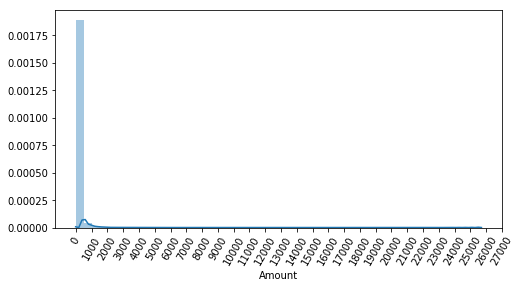

In [10]:
#전체 데이터의 분포를 확인한다. 
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount']) #피처간의 분포가 매우 크기 때문에 정규화의 필요성이 있다. 

In [11]:
#예측성능을 보기 위하여 앞에서 만든 get_processed_df()를 사용하여 sklearn의 StandardScaler 클래스를 사용하여 Amount를 정규변환
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규분포의 형태로 Amount값을 변환하는 식을 작성
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1)) #정규화하여 반환한다. 
    
    #변환된 Amount를 Amount_Scaled로 변경후 삽입
    df_copy.insert(0,'Amount_Scaled', amount_n)
    #기존 Time, Amount feaure의 삭제
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    return df_copy

In [12]:
#Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀의 성능')
lr_clf=LogisticRegression() #로지스틱 회귀 객체 선언
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) #성능평가

로지스틱 회귀의 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.8040


In [13]:
print('LightGBM 예측 성능')
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

LightGBM 예측 성능
오차 행렬
[[85135   160]
 [  128    20]]
정확도: 0.9966, 정밀도: 0.1111, 재현율: 0.1351,    F1: 0.1220, AUC:0.5666


4. StandardScaler후의 정확도에는 큰 개선사항이 없었다. 이에 대해 log변환 후 개선사항을 살펴보고자 한다. 

In [14]:
#데이터가공함수에 로그변환식을 더하여 작성하는 경우
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    #넘파이의 log1p()를 이용하여 Amount를 로그변환
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    return df_copy

In [15]:
#Amount를 로그변환 이후에 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀의 성능')
lr_clf=LogisticRegression() #로지스틱 회귀 객체 선언
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) #성능평가

print('LightGBM 예측 성능')
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
#성능은 개선되었지만 미비한 정도이다. 

로지스틱 회귀의 성능
오차 행렬
[[85283    12]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8824, 재현율: 0.6081,    F1: 0.7200, AUC:0.8040
LightGBM 예측 성능
오차 행렬
[[85274    21]
 [  116    32]]
정확도: 0.9984, 정밀도: 0.6038, 재현율: 0.2162,    F1: 0.3184, AUC:0.6080


5. 이상치 데이터 제거 후 모델 학습/예측/평가

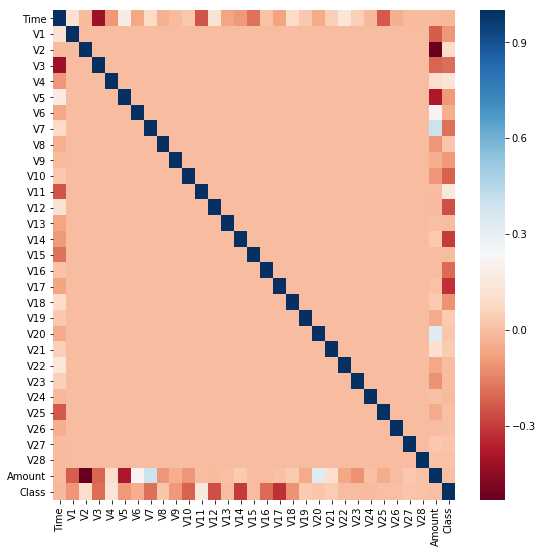

In [16]:
#어떤 feature의 이상치를 제거할 것인지에 대한 선택이 필요하다
#상관성이 높은 feaure의 이상치 제거 후 모델을 적용해야 성능이 더 많이 개선될 것이다. 
#따라서 변수별 상관계수를 heatmap형태로 시각화 할 예정이다. 
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')

양의 상관관계가 높을 수록 색이 진한 파란색에 가까우며 음의 상관관계에 가까울수록 색이 진한 빨간색에 가깝게 표시된다. class피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 

In [20]:
#상관계수가 높은 V14에 대해 이상치를 제거한다. 
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    #fraud에 해당하는 column데이터만 추출, 각 분위수값 추출
    fraud=df[df['Class']==1][column]
    quantile_25=np.percentile(fraud.values,25)
    quantile_75=np.percentile(fraud.values, 75)
    
    #IQR을 구하고 최댓값, 최솟값을 지정한다 
    iqr=quantile_75-quantile_25
    iqr_weight=iqr*weight
    lowest_val=quantile_25-iqr_weight
    highest_val=quantile_75+iqr_weight
    
    #최댓값보다 크거나 최솟값보다 작으면 이상치 데이터를 인덱스로 반환한다. 
    outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

In [21]:
#V14칼럼에서 이상치 데이터를 찾아보겠습니다. 
outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [22]:
#이상치를 제거하는 방법은 get_preprocessed에 추가하여 전처리 작업 함수를 완성하는 방법
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    amount_n=np.log1p(df_copy['Amount']) #변수에 대해 로그변환
    df_copy.insert(0, 'Amount_Scaled', amount_n) #scaled된 값을 대입
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    #이상치 데이터를 삭제하는 로직 추가
    outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [24]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.8355
LightGBM 예측 성능
오차 행렬
[[85233    62]
 [   61    85]]
정확도: 0.9986, 정밀도: 0.5782, 재현율: 0.5822,    F1: 0.5802, AUC:0.7907


4. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [25]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 셋:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 셋:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 셋: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 셋: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [26]:
#오버샘플링으로 학습된 데이터 셋을 기반으로 로지스틱 회귀 모델을 학습한 수 성능을 평가한다. 
lr_clf=LogisticRegression()
#frt_train과 tgt_train 인자값이 SMOTE 증식된 값에 의해 마찬가지로 변동될 것이다. 
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9485


In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

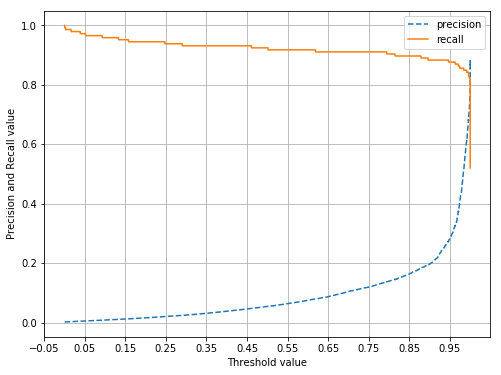

In [29]:
#재현율은 매우 높아지지만 정밀도는 매우 낮아지는 경항이 있음. 
#roc_auc 시각화를 통해 나타난다. 
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [30]:
#임계값을 조절하더라고 임계값의 민감도가 너무 크므로 올바른 예측모델이 되지 못한다. 
#Light GBM를 적용하는 경우
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493,    F1: 0.8889, AUC:0.9246
